In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numba import jit

# Computational Essay
By Roy Lim z5310629

# Introduction & Background
During this assignment, we are tasked with numerically simulating how quantum dots behave in different scenario, which include:
- Single vs Double Quantum Dots
- Detuning Bias
- Time-dependence / evolution of states over time

A double quantum dot with a detuning bias applied can be used as a qubit, which motivates our work. 

# Results & Discussion

### Part A
We can solve the Hamiltonian:
$$
    H = 
    \begin{bmatrix}
    E & t \\
    t* & -E \\ 
    \end{bmatrix}
$$
to get the following eigenvalues: $\lambda_1 = -\sqrt{t^2 + E^2} $, $\lambda_2 = \sqrt{t^2 + E^2}$ and given eigenvectors:
$$
    | \lambda_2 \rangle = 
    \begin{bmatrix}
        E - \sqrt{t^2 + E^2} \\ 
        t
    \end{bmatrix}
    | \lambda_2 \rangle = 
    \begin{bmatrix}
       E + \sqrt{t^2 + E^2} \\ 
       t 
    \end{bmatrix}
$$
Therefore $E_2 - E_1 = 2\sqrt{t^2 + E^2}$, min value for $E_2 - E_1$ is $2t$

For an energy state $| \lambda \rangle = \begin{bmatrix} a \\ b\end{bmatrix}$, the probability of being in state $|0\rangle$ and $|1\rangle$ is $|a|^2$ and $|b|^2$ respectively.
Note that $|a|^2 + |b|^2 = 1$ and that $t$ is real (meaning $t* = t$)

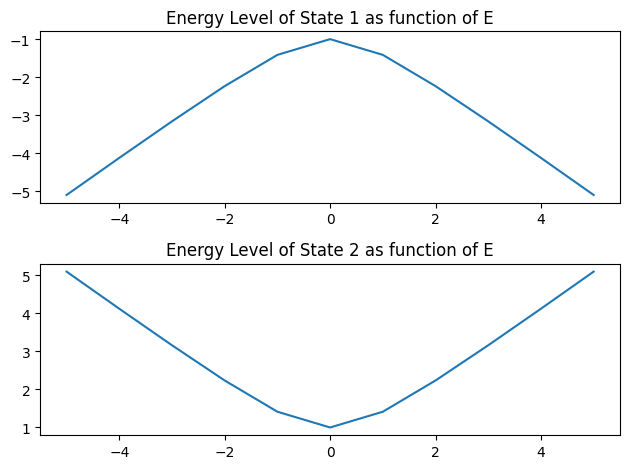

In [10]:
t = 1
E = [e for e in range(-5, 6)]
fig, axes = plt.subplots(2)
state1 = axes[0]
state2 = axes[1]
state1.plot([e for e in E], [-np.sqrt(t ** 2 + e ** 2)for e in E])
state1.set_title('Energy Level of State 1 as function of E')
state2.plot([e for e in E], [np.sqrt(t ** 2 + e ** 2)for e in E])
state2.set_title('Energy Level of State 2 as function of E')
plt.tight_layout()

In [11]:
# a = E, b = t
probability_matrix = [
    [
        lambda a, b: (a + np.sqrt(a ** 2 + b ** 2)) ** 2 / ((a + np.sqrt(a ** 2 + b ** 2)) ** 2 + b ** 2),
        lambda a, b:  b ** 2 / ((a + np.sqrt(a ** 2 + b ** 2)) ** 2 + b ** 2),
    ],
    [
        lambda a, b: (a - np.sqrt(a ** 2 + b ** 2)) ** 2 / ((a - np.sqrt(a ** 2 + b ** 2)) ** 2 + b ** 2),
        lambda a, b:  b ** 2 / ((a - np.sqrt(a ** 2 + b ** 2)) ** 2 + b ** 2),
    ]
]

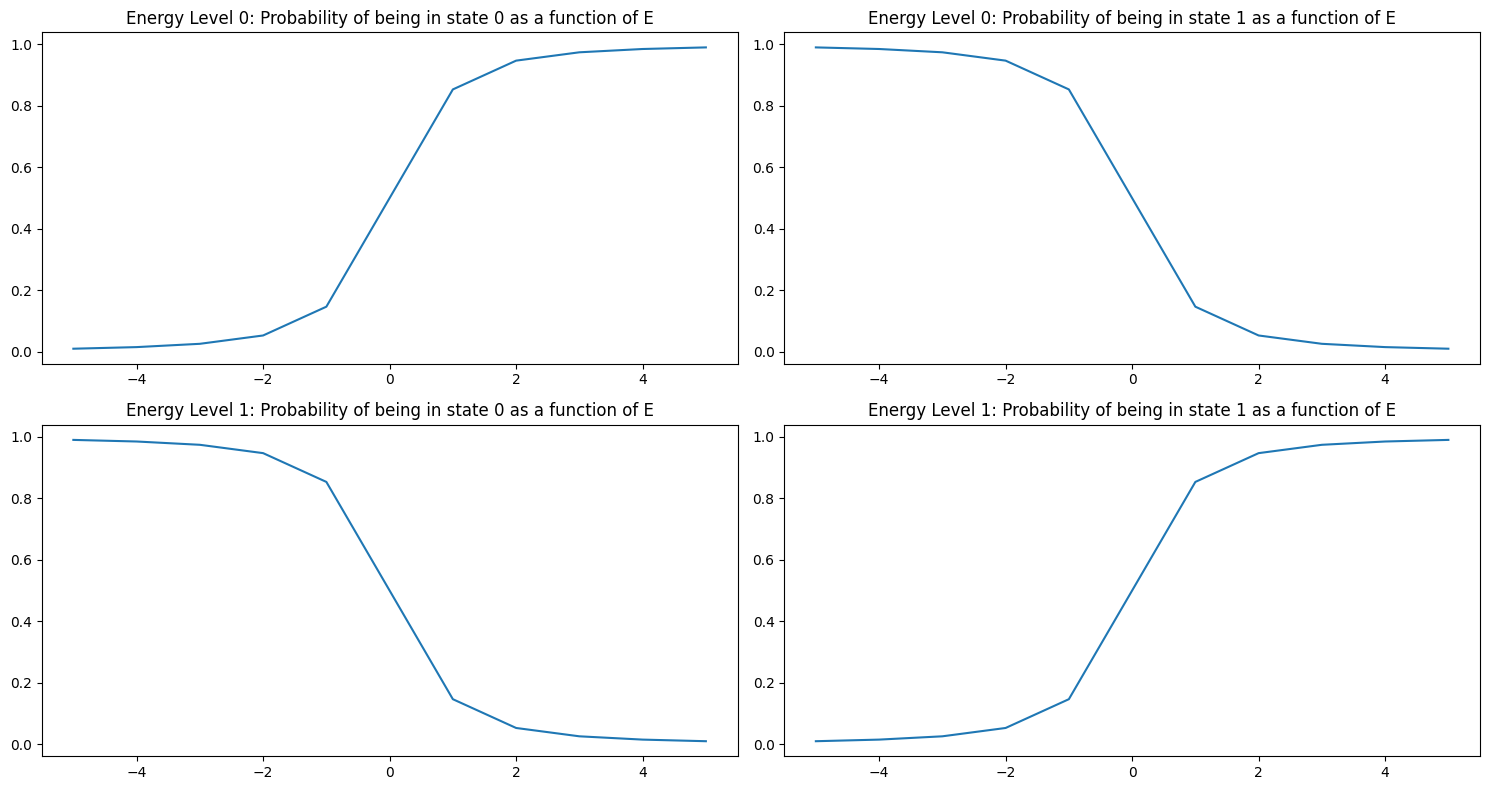

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
for energy_level in [0, 1]:
    for state in [0, 1]:
        ax = axes[energy_level, state]
        ax.plot([e for e in E], [probability_matrix[energy_level][state](e, t) for e in E], '-')
        ax.set_title(f'Energy Level {energy_level}: Probability of being in state {state} as a function of E')
        
plt.tight_layout()

### Part B

In [13]:
# Physical Constants
hbar = 1.055e-34      # Js
q = 1.602e-19         # C
m = 9.1e-31           # kg
m_dot = 0.2 * m       # kg  
bohr_radii = 5.29e-11 # m
a = 1e-10             # m

In [14]:
def VQD(alpha, x1, x):
    return alpha * (x - x1) ** 2

def VDQD(alpha, x1, x2, x):
    return alpha * min((x - x1) ** 2, (x - x2) ** 2)

def VF(alpha, F, x1, x2, x):
    return alpha * min((x - x1) ** 2, (x - x2) ** 2) + F * x

def VFT(alpha, F, omega, x1, x2, x, t):
    return alpha * min((x - x1) ** 2, (x - x2) ** 2) + F * x * np.cos(omega * t)

In [29]:
@jit
def construct_H(U):
    return np.diag(on + U) + np.diag(off, 1) + np.diag(off, -1)
@jit
def compute_eigenvalue_eigenstates(U):
    H = construct_H(U)
    W, V = np.linalg.eig(H)
    idx = W.argsort()[::1]
    W = W[idx]
    V = V[:, idx]
    return W, V

Recall for a 1D Quantum Harmonic Oscillator:
$$
    H = \frac{p^2}{2m} + \frac{1}{2}m\omega^2 x^2
$$,
hence $\alpha = \frac{1}{2} m \omega^2$
Using $\omega = \frac{E_1 - E_0}{\hbar}$, we can deduce that:
$$
\alpha = \frac{1}{2}m ( \frac{(E_1 - E_0)}{\hbar} )^2
$$
Assuming an energy gap of $4 meV$, we get an alpha value of $\approx 2.1 \frac{eV}{nm^2}$.

In [28]:
print(f'Alpha Estimate (Analytical): {1 / 2 * m_dot * (4 * 1e-3 * q / hbar) ** 2 * 1e-9 ** 2 / q :.2E} eV / nm^2') 

Alpha Estimate (Analytical): 2.10E-05 eV / nm^2


In [226]:
# Constants
Np = 700
X = a * np.linspace(-Np / 2, Np / 2, Np) / 1e-9  # nm
# divide by q to convert to eV, accounting for mass of quantum dot ~ 0.2 mass of electron
t0 = hbar ** 2 / (2 * m_dot * ((X[1] - X[0]) * 1e-9) ** 2) / q
on = 2.0 * t0 * np.ones(Np)
off = -t0 * np.ones(Np - 1)
alpha = 2.10e-5 
x1 = 0 # nm

#### Sweeping Potential Energy 

In [227]:
for pow in range(-5, 0):
    alpha_test = 10 ** pow
    U = np.array([VQD(alpha_test, x1,  x) for x in X])
    W, _ = compute_eigenvalue_eigenstates(U)
    print(f'Alpha {alpha_test:.2E} yields Energy Gap of {(W[1] - W[0]) / 1e-3 :.2f} meV')

Alpha 1.00E-05 yields Energy Gap of 2.78 meV
Alpha 1.00E-04 yields Energy Gap of 8.74 meV
Alpha 1.00E-03 yields Energy Gap of 27.63 meV
Alpha 1.00E-02 yields Energy Gap of 87.35 meV
Alpha 1.00E-01 yields Energy Gap of 276.06 meV


#### Computation for Energy Gap of 4meV

In [228]:
U = np.array([VQD(alpha, x1,  x) for x in X])
W, V = compute_eigenvalue_eigenstates(U)

In [229]:
print(f'Energy Gap: {(W[1] - W[0]) / 1e-3} meV')

Energy Gap: 4.0049505134046095 meV


In [230]:
Psi0 = np.multiply(V[:, 0], V[:, 0])
Psi1 = np.multiply(V[:, 1], V[:, 1])

Text(0.5, 1.0, '$|\\psi_1|^2$')

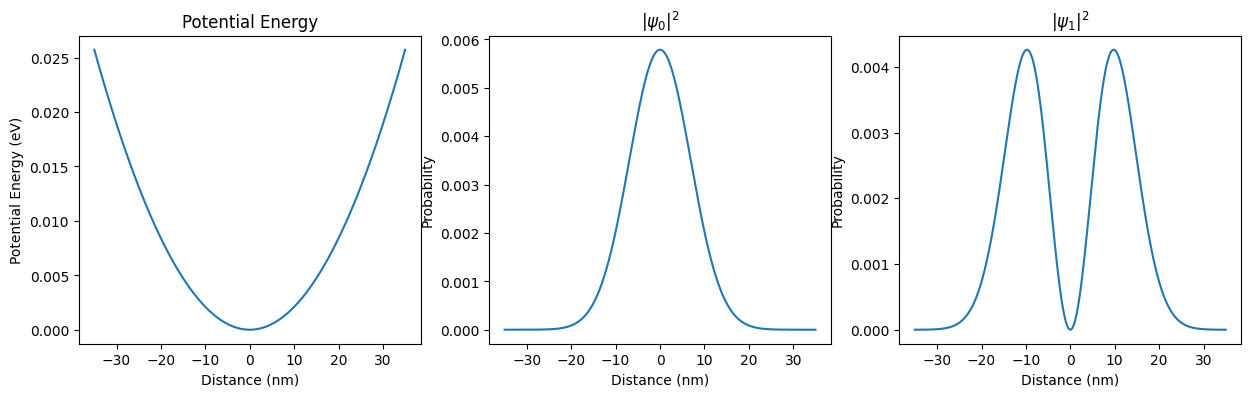

In [231]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(X, U)
axes[0].set_xlabel('Distance (nm)')
axes[0].set_ylabel('Potential Energy (eV)')
axes[0].set_title(r'Potential Energy')

axes[1].plot(X, Psi0)
axes[1].set_xlabel('Distance (nm)')
axes[1].set_ylabel('Probability')
axes[1].set_title(r'$|\psi_0|^2$')


axes[2].plot(X, Psi1)
axes[2].set_xlabel('Distance (nm)')
axes[2].set_ylabel('Probability')
axes[2].set_title(r'$|\psi_1|^2$')

In [36]:
def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def fit_gaussian(x, y, p0):
    popt, _ = curve_fit(gauss, x, y, p0)
    return popt
A, mu, sigma = fit_gaussian(X, Psi0, [.05, 0, 5])
print(f'Number of Atoms Spanned: {2 * sigma * 1e-9 / 0.543e-9:.2F}')

Number of Atoms Spanned: 25.43


/home/roy/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


#### i)
Given the alpha is related to the potential energy of the gate, used the confined the electron, we can infer that alpha must be related to how the gate interacts with the material.

Thus factors that affect the value may include:
- Voltage applied by the gate
- Distance between gate and trapped electron (e.g. a thicker $SiO_2$ layer could affect alpha)
- The dimensions of the gate / how the voltage is spread out

Temperature range we expect for the device to work would be low (close to 0K), otherwise the thermal fluctuation may cause decoherence.
This is because higher temperature leads to more active electrons and atoms, which increase the likelihood of interaction, leading to decoherence.
Alternatively, high temperature may lead to the confined electrons from moving out of its confinement, thus destroying the ability of it actions as a qubit.
Additionally, $T << \hbar \omega$ (where $\hbar \omega$ is the energy between energy levels in a quantum harmonic oscillator) (this condition is necessary otherwise we wouldn't be able to distinguish between the different states).
  
#### ii)
Using Finite Difference method, the increment $\Delta x$ should be $1 \AA$, but due to limitation of floating point numbers, it tends to deviate slightly from this value, which affects the energy gap and length scale of wave function.

The simulation domain also affects the result. 
Due to the limitation of FDM, we are simulating both a particle in a finite potential well and a quantum harmonic oscillator.
This means the wave function is affected by both. 
To remedy this, I expanded the simulation domain until length scale and energy gap began to converge / remain constant (this occurred at $Np = 700$ and a domain between $-35nm$ and $35nm$.   

#### iii)
Quantum dots are called artificial atoms as they have discrete energy levels similar to how electrons do in an atom.
Length scale is 2$\sigma$ of a gaussian fitted on the probability density of being in ground.
Around 25.43 atoms can fit within the length scale (I fitted a Gaussian to the ground state wave function and took $2\sigma$ (2 times standard deviation) to be the length scale.



### Part C

In [37]:
def plot_graph(x, y, xlabel, ylabel, title, axis=None):
    if axis is not None:
        axis.plot(x, y)
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        axis.set_title(title)
    else:
        plt.plot(x, y)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)

In [38]:
def plot_graph_x(x, y, xlabel, ylabel, title, axis=None):
    if axis is not None:
        axis.plot(x, y, 'x')
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        axis.set_title(title)
    else:
        plt.plot(x, y, 'x')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)

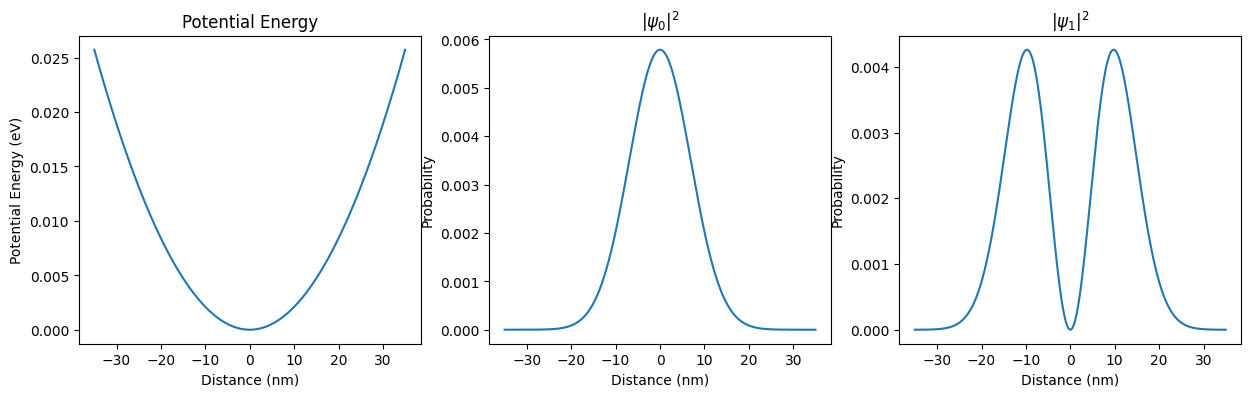

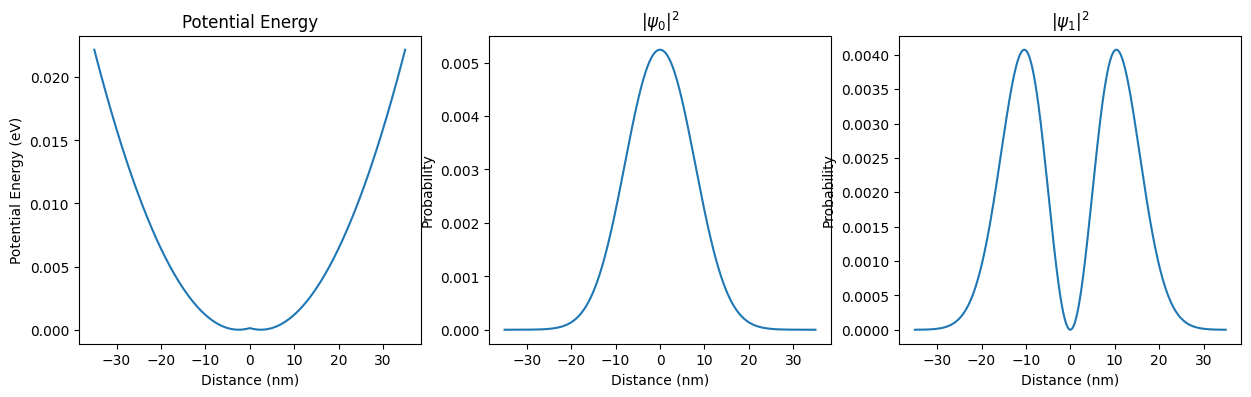

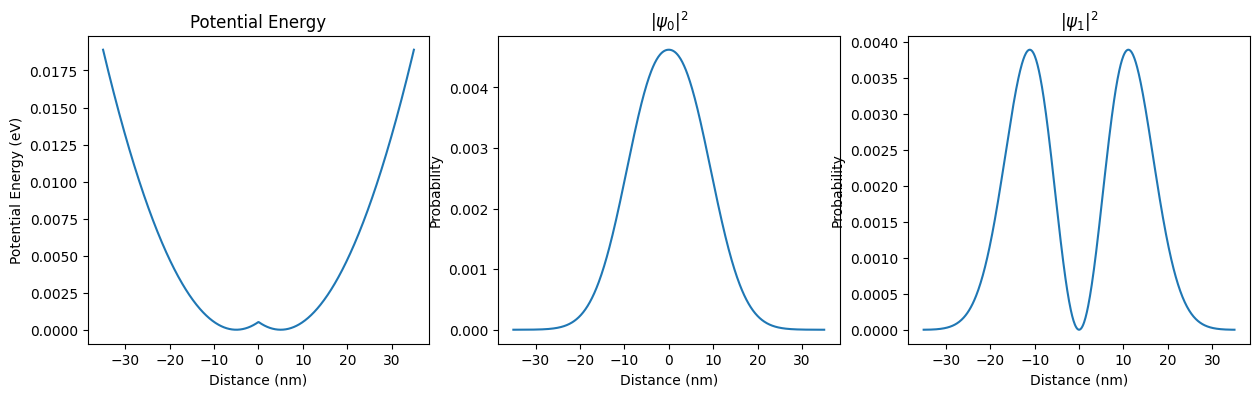

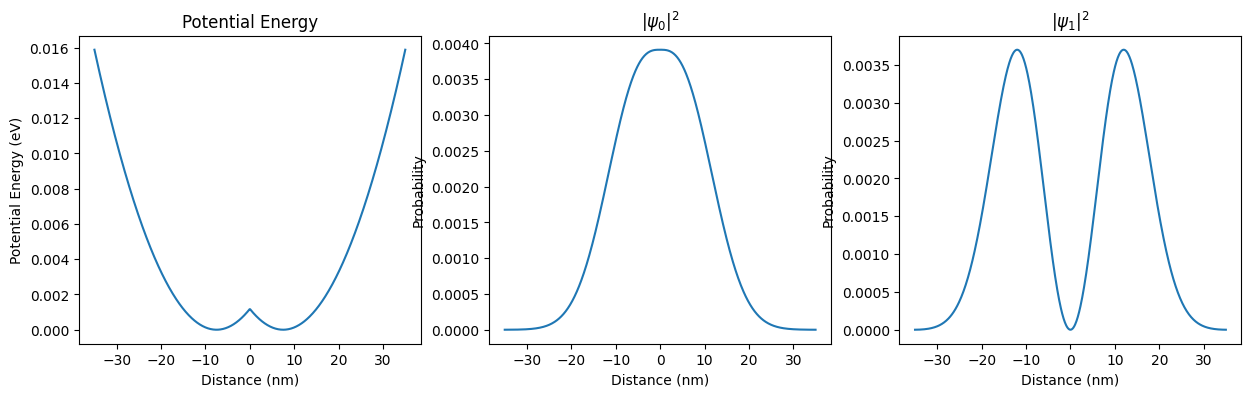

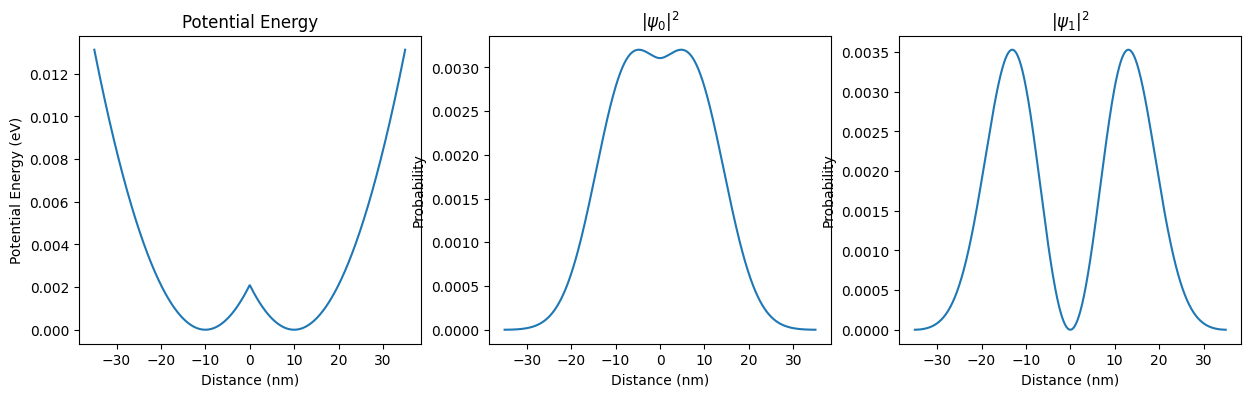

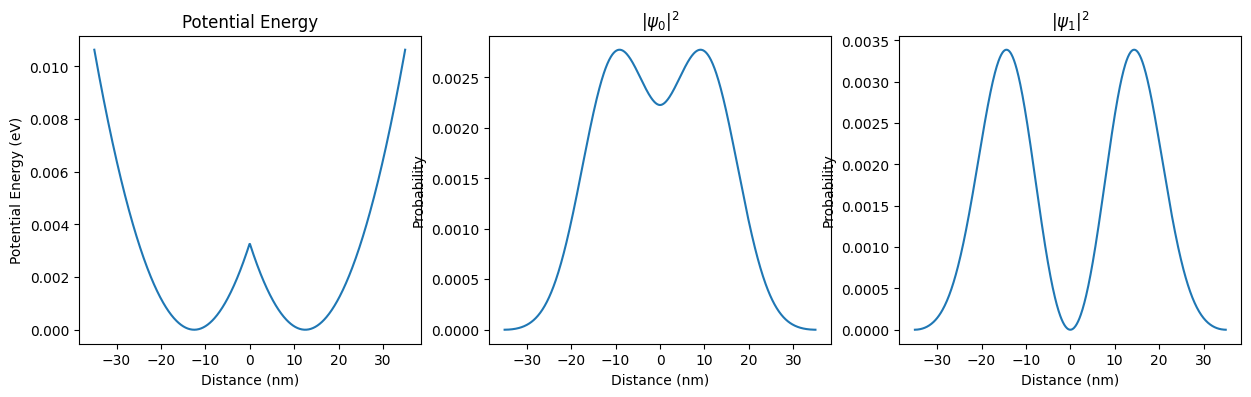

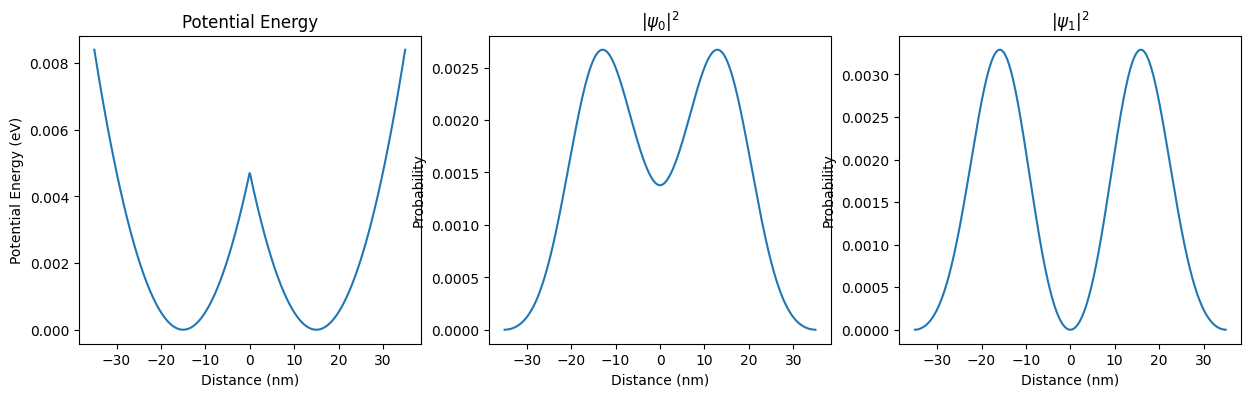

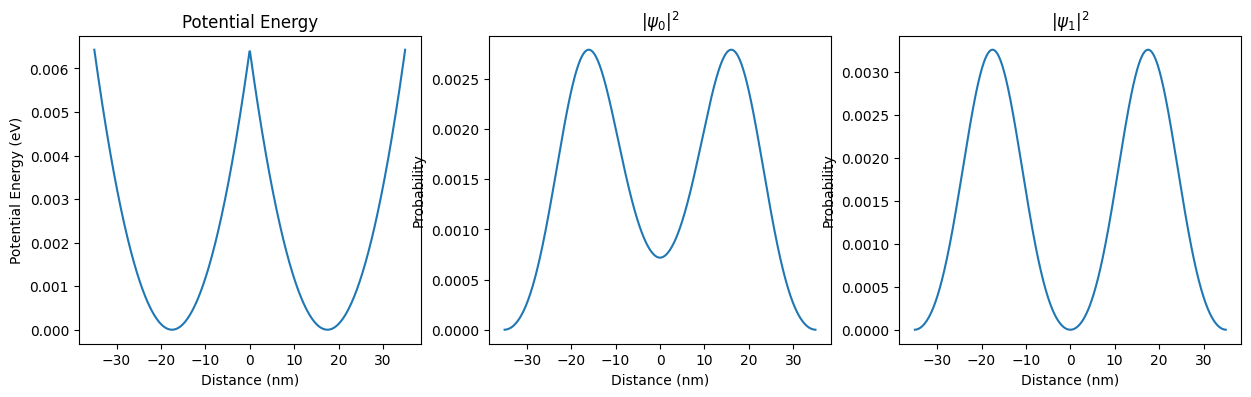

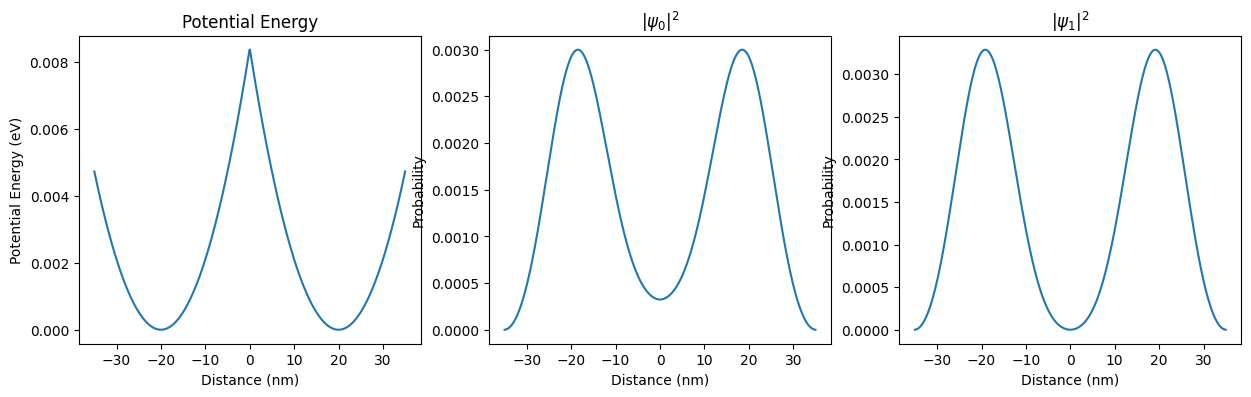

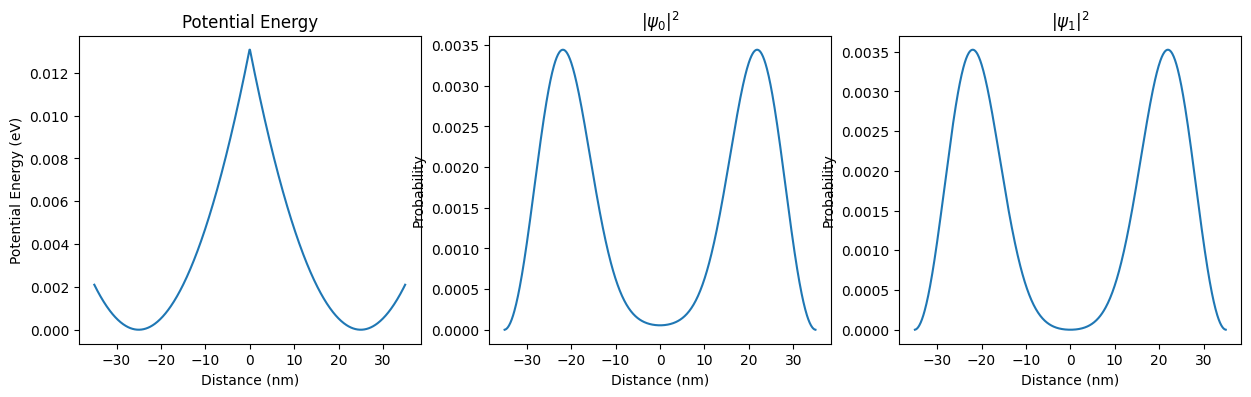

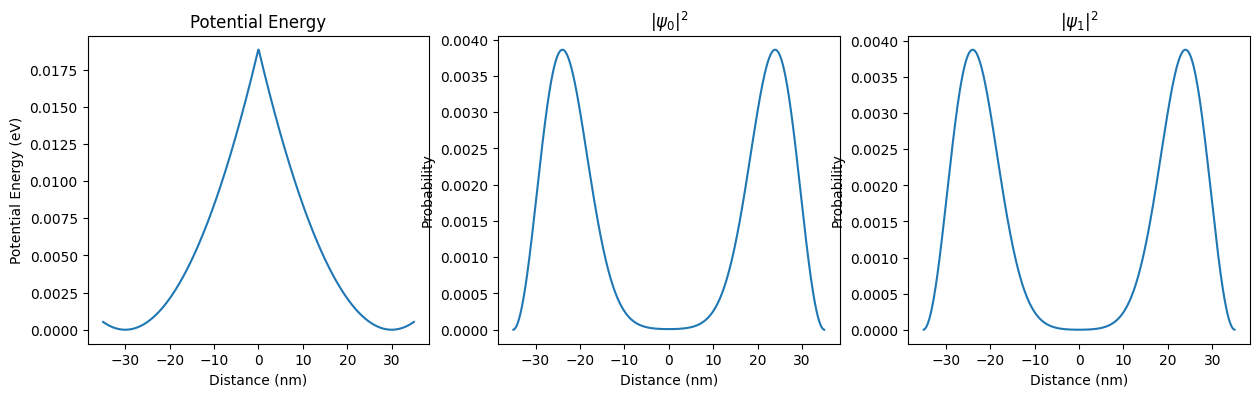

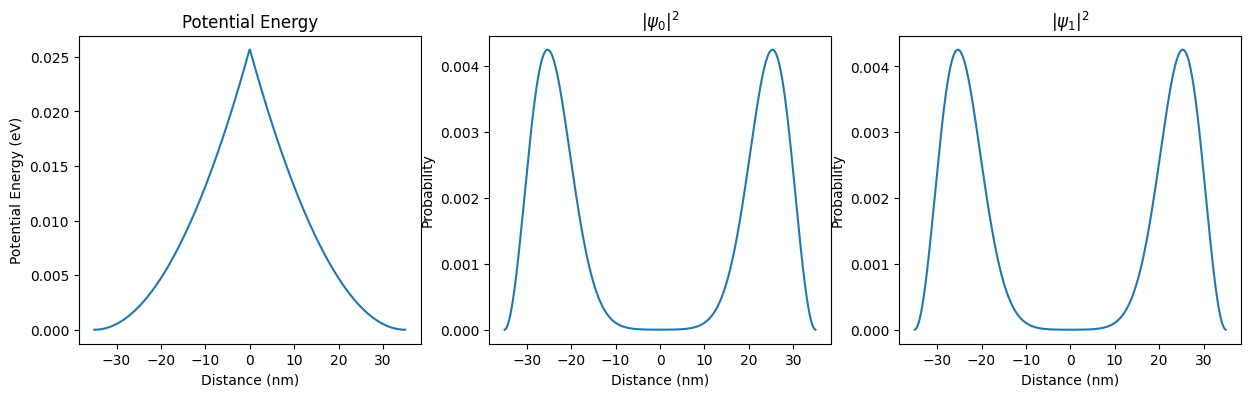

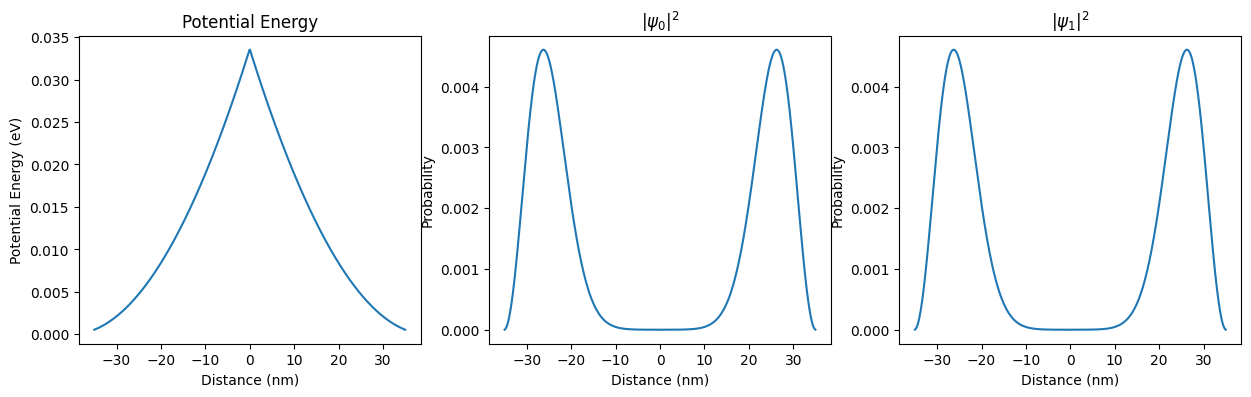

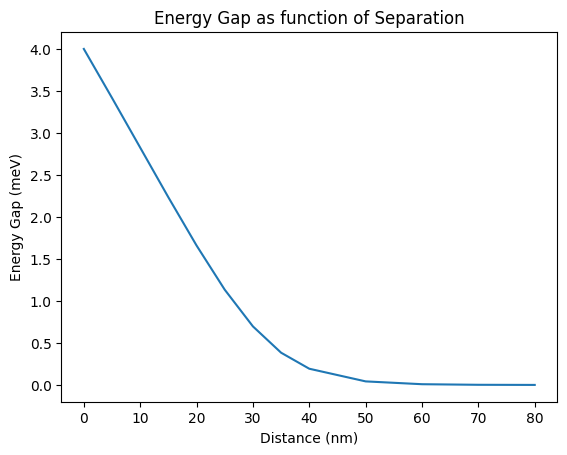

In [40]:
# Plotting how wave function and potential energy changes with dot-to-dot seperation
separation = []
energy_difference = []

for index, R in enumerate([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 25, 30, 35, 40]):
    x1 = R
    x2 = -R
    # Create Potential Energy and Probability Curves for 2 lowest energy state
    U = np.array([VDQD(alpha, x1, x2, x) for x in X])
    W, V = compute_eigenvalue_eigenstates(U)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    Psi0 = np.multiply(V[:, 0], V[:, 0])
    Psi1 = np.multiply(V[:, 1], V[:, 1])
    plot_graph(X, U, 'Distance (nm)', 'Potential Energy (eV)', r'Potential Energy', axes[0])
    plot_graph(X, Psi0, 'Distance (nm)', 'Probability', r'$|\psi_0|^2$', axes[1])
    plot_graph(X, Psi1, 'Distance (nm)', 'Probability', r'$|\psi_1|^2$', axes[2])
    plt.show()

    # Create data for energy difference per centre-to-centre dot separation
    separation.append(2 * R)
    energy_difference.append((W[1] - W[0]) / 1e-3)

plot_graph(separation, energy_difference, 'Distance (nm)', 'Energy Gap (meV)', 'Energy Gap as function of Separation')

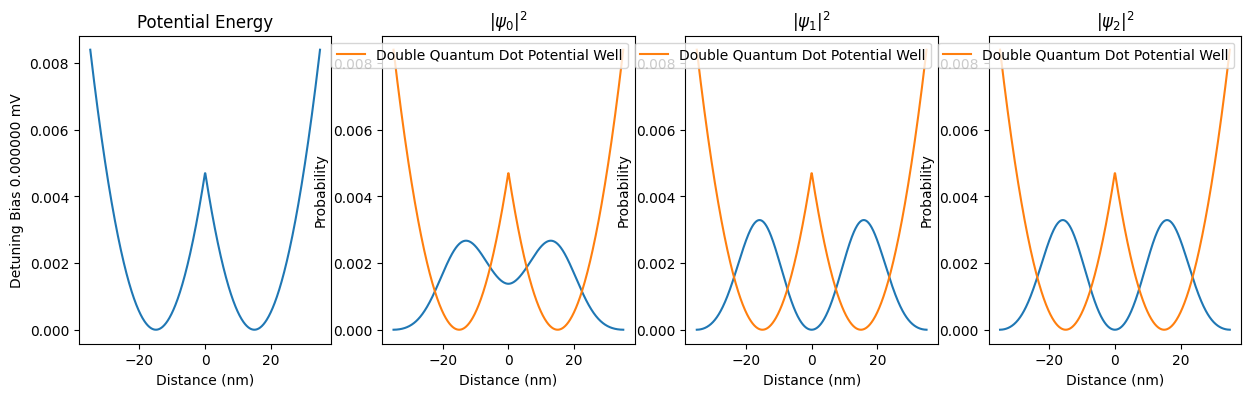

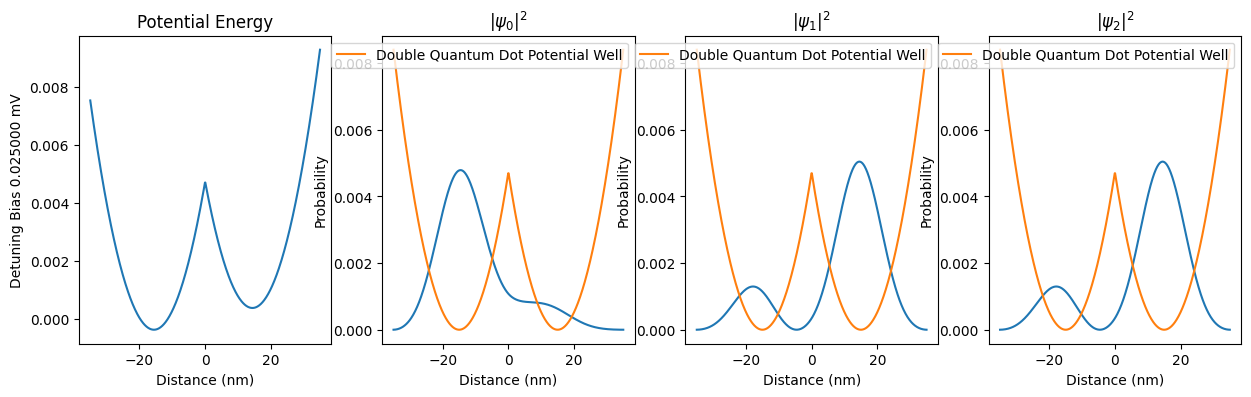

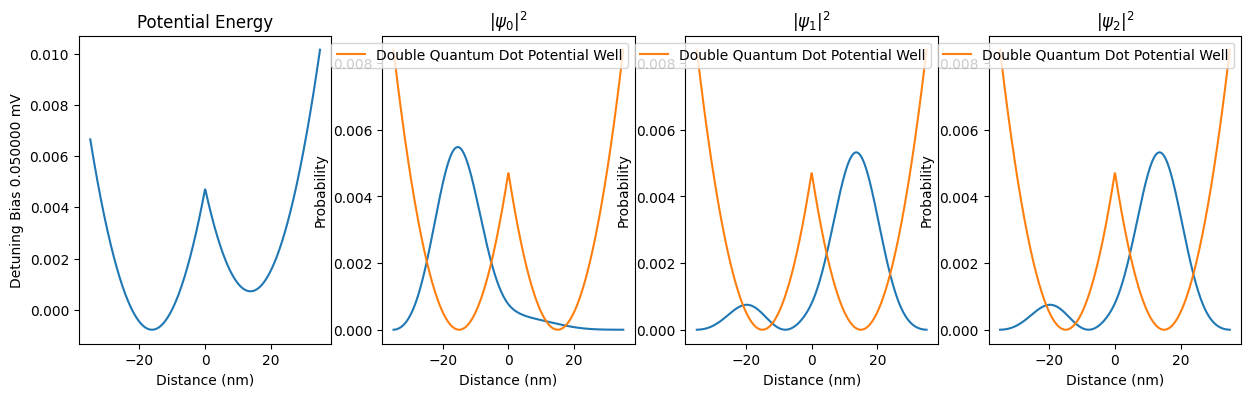

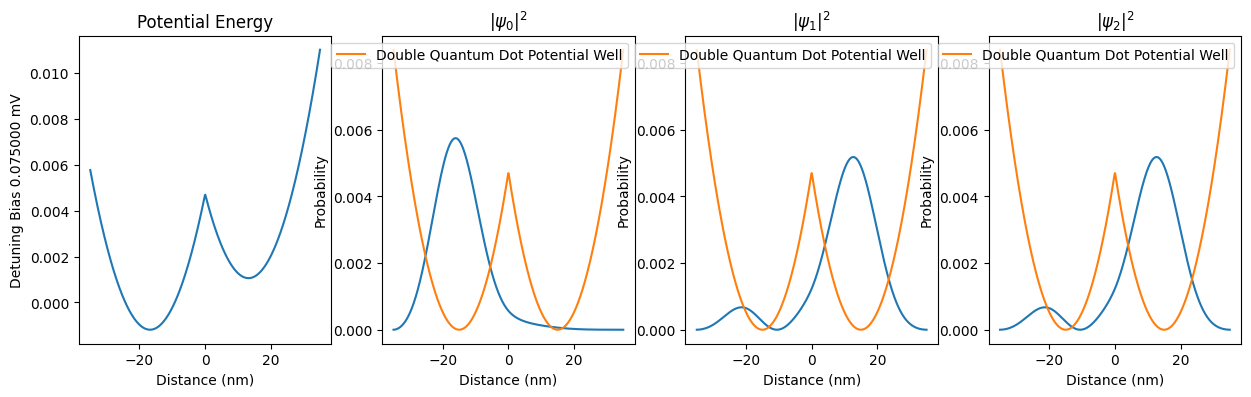

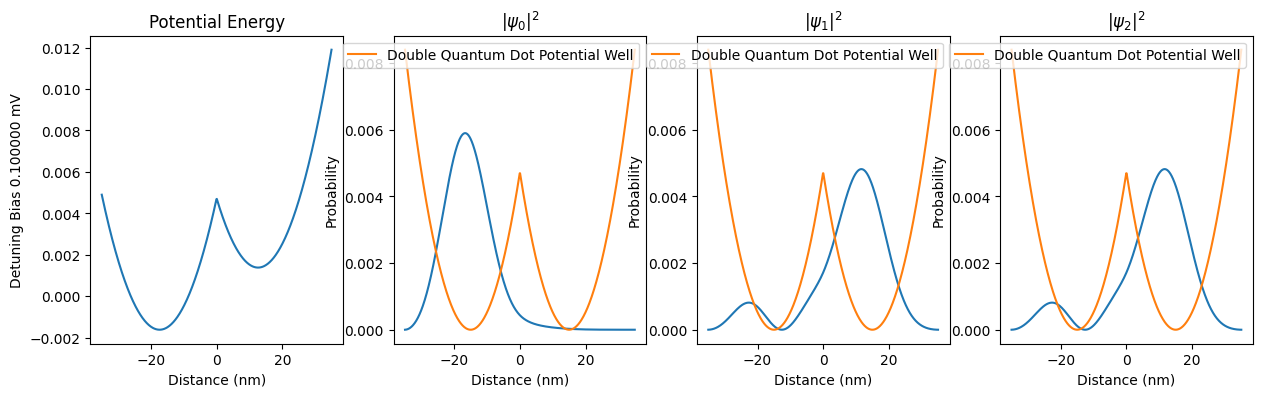

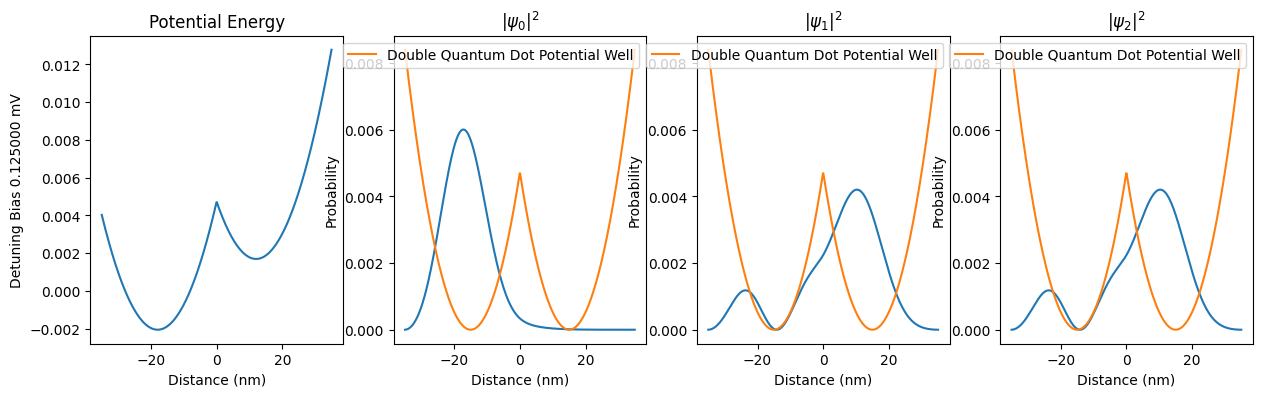

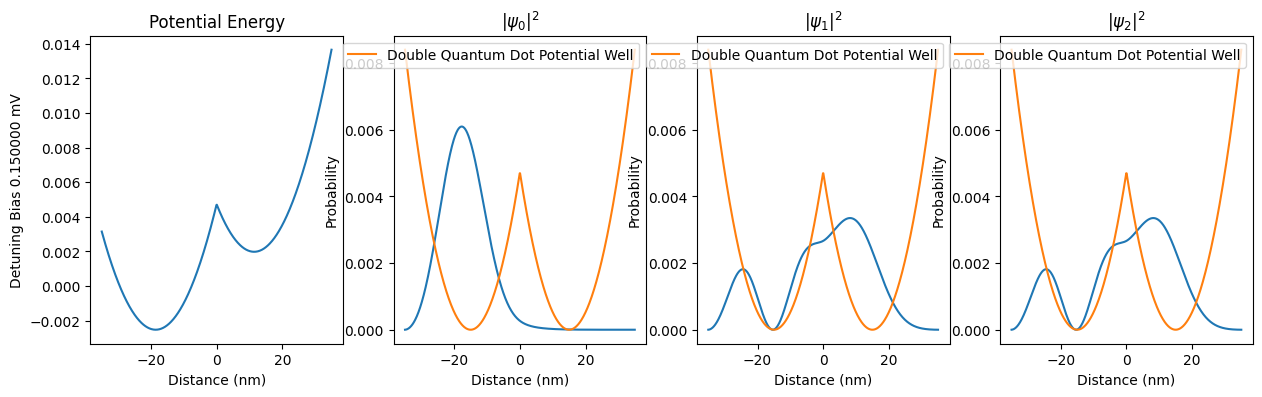

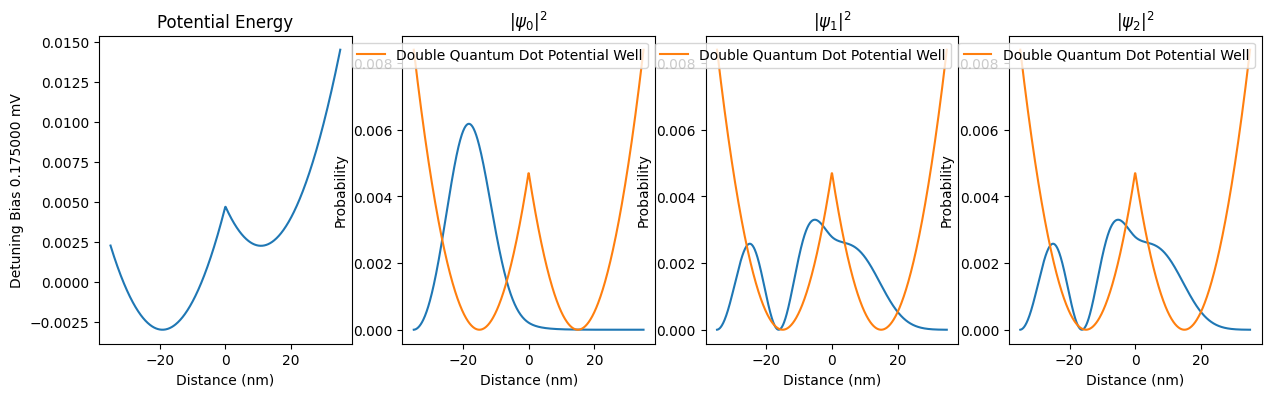

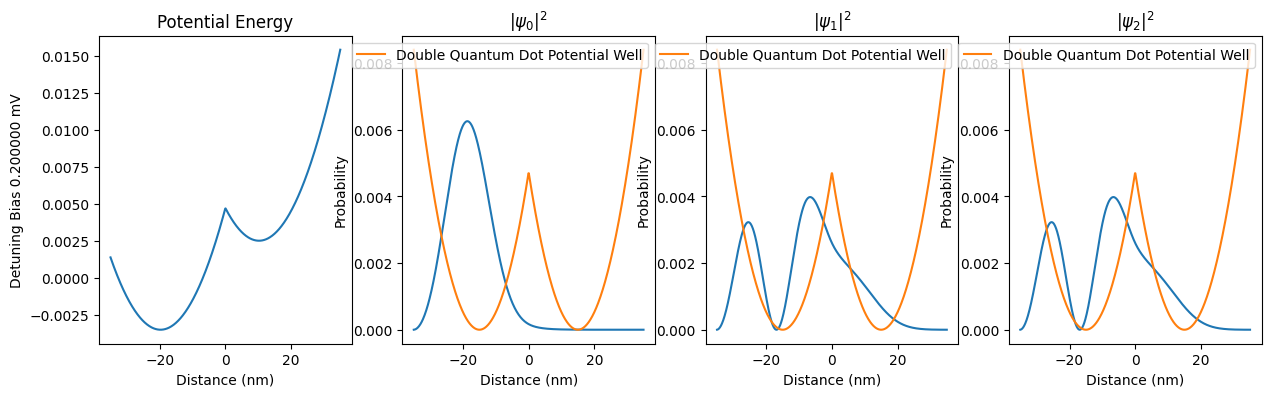

In [41]:
# Plotting how wave function and potential changes with detuning bias F
x1, x2 = 15, -15
FArray = np.arange(0, 20.1, 2.5) * 1e-5
eigen1 = np.array([])
eigen2 = np.array([])

for F in FArray:
    U = np.array([VF(alpha, F, x1, x2, x) for x in X])
    W, V = compute_eigenvalue_eigenstates(U)
    eigen1 = np.append(eigen1, W[0])
    eigen2 = np.append(eigen2, W[1])
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    Psi0 = np.multiply(V[:, 0], V[:, 0])
    Psi1 = np.multiply(V[:, 1], V[:, 1])
    plot_graph(X, U, 'Distance (nm)', f'Detuning Bias {F / 1e-3 :2F} mV', r'Potential Energy', axes[0])
    plot_graph(X, Psi0, 'Distance (nm)', 'Probability', r'$|\psi_0|^2$', axes[1])
    plot_graph(X, Psi1, 'Distance (nm)', 'Probability', r'$|\psi_1|^2$', axes[2])
    plot_graph(X, Psi1, 'Distance (nm)', 'Probability', r'$|\psi_2|^2$', axes[3])
    axes[1].plot(X, np.array([VDQD(alpha, x1, x2, x) for x in X]), label='Double Quantum Dot Potential Well')
    axes[2].plot(X, np.array([VDQD(alpha, x1, x2, x) for x in X]), label='Double Quantum Dot Potential Well')
    axes[3].plot(X, np.array([VDQD(alpha, x1, x2, x) for x in X]), label='Double Quantum Dot Potential Well')
    axes[1].legend()
    axes[2].legend()
    axes[3].legend()
    plt.show()
    

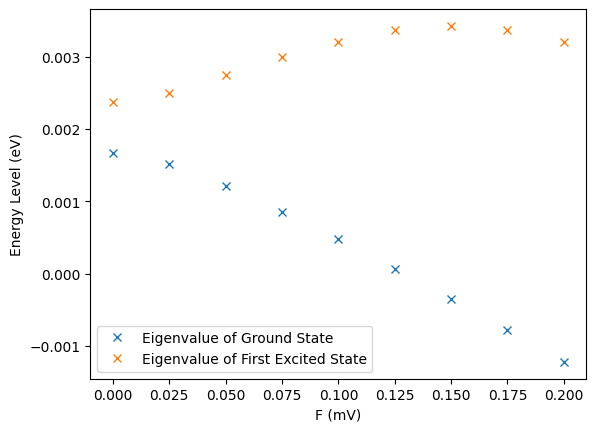

In [42]:
plt.plot(FArray / 1e-3, eigen1, 'x', label='Eigenvalue of Ground State')
plt.plot(FArray / 1e-3, eigen2, 'x', label='Eigenvalue of First Excited State')
plt.ylabel('Energy Level (eV)')
plt.xlabel('F (mV)')
plt.legend()

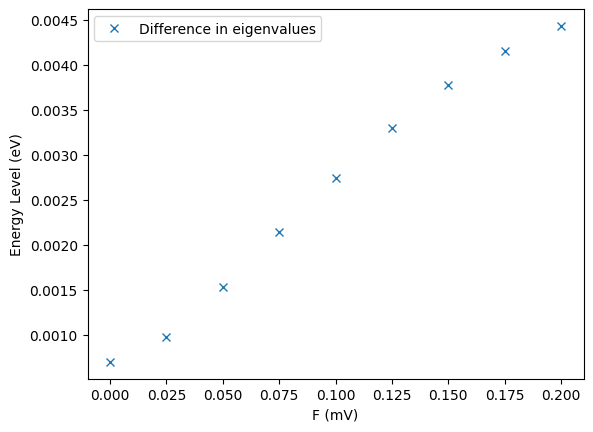

In [43]:
plt.plot(FArray / 1e-3, eigen2 - eigen1, 'x', label='Difference in eigenvalues')
plt.ylabel('Energy Level (eV)')
plt.xlabel('F (mV)')
plt.legend()

#### i)
The probability density for the ground state goes from uni-modal to bi-modal as the separation distance $R$ increases (i.e. becomes more similar to the first excited state).
The probability density for the first excited state doesn't go through much change.
This is reflected in the energy gap, when the gap is large, the probability density for ground and first excited state are dissimilar and gradually become more similar as the energy gap decreases.


##### ii)
Energy gap between the first two energy states decrease as separation $R$ increases, eventually plateauing around 50-60nm. 

Modifying the dot-to-dot separation affects the off-diagonal entries $t$ since it affects the energy gap between the first two energy states.
In a classical system, while there are no quantum dots, the off-diagonal entries typically representing coupling (e.g. in the case of a classical coupled pendulums, how coupled pendulums are with each others oscillation).
  
Dot separation is physically represented by the separation of the gates used to create the quantum dots.
There is an optimal separation for double quantum dots.
If the separation is too small, then it becomes difficult to determine the position of the electron (i.e difficult to get a read-out).
If the separation is too high, then the electron will no longer be in a state of superposition between the left and right gate, meaning it difficult to use as qubit.
This means we need to find an optimal separation whereby the first two energy states are sufficiently separated from the other energy states while also ensuring it has the properties that we need.  
  
##### iii)
When the sign of $F$ changes, the probability density function shifts in the opposite direction (i.e. the most probably position of the electron will move from the right to the left and vice versa when $F$ changes signs).
For instance, a positive $F$ encourages electrons to the left of the centre of the dot, while a negative $F$ encourages electrons to move to the right side.

It appears that the energy gap between the lowest energy as the magnitude of $F$ increases.
From A, the energy difference is only dependent on the coupling terms $t$ and $t*$.
This means that $F$ affects $t$ in our Hamiltonian (i.e. the off-diagonal entries)

Values for $F$ where a qubit can operate is between $0$ and $0.1 mV/m$   for a double quantum dot system with a separation of $30nm$.
The value for $F$ must ensure that the electron remains in a state of superposition between the right and left gate (i.e. we need to ensure that all the peaks for a wave function aren't all on one side of potential well, i.e. we want the electrons to be in a superposition between left and right gate).   
The range can be visually inferred by looking at how the wave function behaves, specifically we ensure that the wave function doesn't favour one side of the well to heavily.

#### Part D

In [204]:
# Spatial Constants
x1, x2 = 15, -15 
F = 0.0615e-3

U = np.array([VDQD(alpha, x1, x2, x) for x in X])
W, V = compute_eigenvalue_eigenstates(U)

In [205]:
omega = (W[1] - W[0]) / hbar * q
print(f'Energy Gap is {(W[1] - W[0]).real * 1e3:.2F} meV')
print(f'Frequency of Oscillation is {omega.real / (2 * np.pi):.2E} s')
print(f'Period of Oscillation is {2 * np.pi / omega.real:.2E} Hz')

Energy Gap is 0.70 meV
Frequency of Oscillation is 1.69E+11 s
Period of Oscillation is 5.93E-12 Hz


In [206]:
# Temporal Constants
Nt = 100
T = np.linspace(0, 8 * np.pi / omega, Nt)         # s (4 times the period)
dt = T[1] - T[0]                                  # s

In [207]:
def probability_over_time_2X2_system(initial_state, H):
    psi = initial_state
    p0 = np.array([np.abs(psi @ V[:, 0]) ** 2])
    p1 = np.array([np.abs(psi @ V[:, 1]) ** 2])

    for i in range(1, Nt):
        t = T[i]
        U_new = np.array([VFT(alpha, F, omega, x1, x2, x, t) for x in X])
        H_new = construct_H(U_new).astype(np.complex128)
    
        A = (np.identity(Np) + 1j * dt / (2 * hbar) * H_new * q)
        B = (np.identity(Np) - 1j * dt / (2 * hbar) * H * q) @ psi
        psi_new = np.linalg.solve(A, B)
    
        pr0 = np.abs(psi_new @ V[:, 0]) ** 2
        pr1 = np.abs(psi_new @ V[:, 1]) ** 2
    
        p0 = np.append(p0, pr0)
        p1 = np.append(p1, pr1)
    
        psi = psi_new
        H = H_new
    
    plt.plot(T, p0, label='Ground State')
    plt.plot(T, p1, label='First Excited State')
    plt.title('Probability of being in State 0 and 1 over time')
    plt.xlabel('Time (s)')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

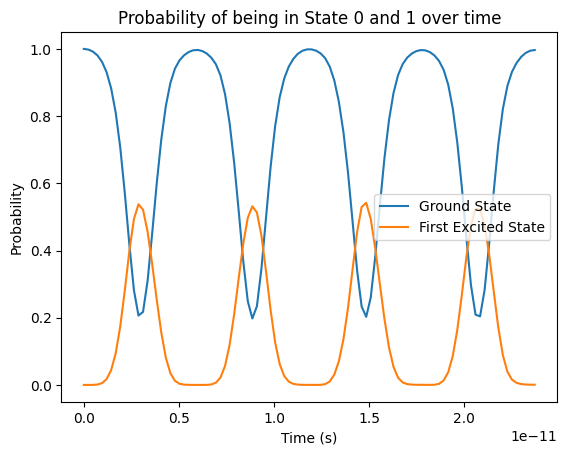

In [208]:
U = np.array([VFT(alpha, F, omega, x1, x2, x, 0) for x in X])
W, V = compute_eigenvalue_eigenstates(U)

psi = np.array(V[:, 0], dtype=np.complex128)
H = construct_H(U).astype(np.complex128)

probability_over_time_2X2_system(psi, H)

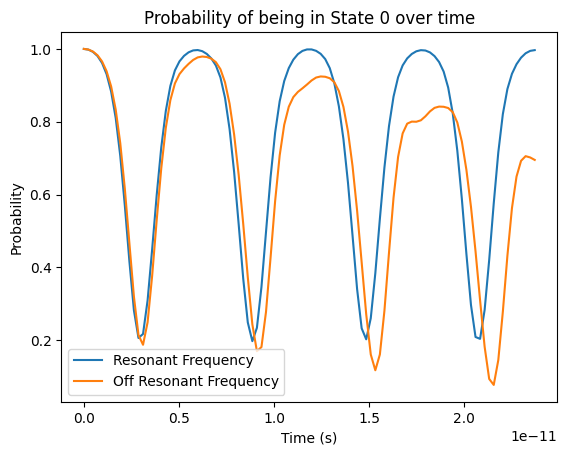

In [209]:
# Resonant Frequency
U = np.array([VFT(alpha, F, omega, x1, x2, x, 0) for x in X])
W, V = compute_eigenvalue_eigenstates(U)

psi = np.array(V[:, 0], dtype=np.complex128)
H = construct_H(U).astype(np.complex128)

p_res = np.array([np.abs(psi @ V[:, 0]) ** 2])

for i in range(1, Nt):
    t = T[i]
    U_new = np.array([VFT(alpha, F, omega, x1, x2, x, t) for x in X])
    H_new = construct_H(U_new).astype(np.complex128)
    
    A = (np.identity(Np) + 1j * dt / (2 * hbar) * H_new * q)
    B = (np.identity(Np) - 1j * dt / (2 * hbar) * H * q) @ psi
    psi_new = np.linalg.solve(A, B)
    
    pr0 = np.abs(psi_new @ V[:, 0]) ** 2
    
    p_res = np.append(p_res, pr0)  
    
    psi = psi_new
    H = H_new
    
# Off Resonant Frequency
U = np.array([VFT(alpha, F, 0.95 * omega, x1, x2, x, 0) for x in X])
W, V = compute_eigenvalue_eigenstates(U)

psi = np.array(V[:, 0], dtype=np.complex128)
H = construct_H(U).astype(np.complex128)

p_off_res = np.array([np.abs(psi @ V[:, 0]) ** 2])

for i in range(1, Nt):
    t = T[i]
    U_new = np.array([VFT(alpha, F, 0.95 * omega, x1, x2, x, t) for x in X])
    H_new = construct_H(U_new).astype(np.complex128)

    A = (np.identity(Np) + 1j * dt / (2 * hbar) * H_new * q)
    B = (np.identity(Np) - 1j * dt / (2 * hbar) * H * q) @ psi
    psi_new = np.linalg.solve(A, B)

    pr0 = np.abs(psi_new @ V[:, 0]) ** 2

    p_off_res = np.append(p_off_res, pr0)

    psi = psi_new
    H = H_new

plt.plot(T, p_res, label='Resonant Frequency')
plt.plot(T, p_off_res, label='Off Resonant Frequency')
plt.title('Probability of being in State 0 over time')
plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.show()

#### i) 
I kept the value for $\alpha$ used in previous
The main parameters that affect the simulation are:
- F (applied field) 
- Dot-to-Dot Separation (R)

We ended up using:
- $\alpha = 2.1 eV / nm^2$
- $F = 0.0615 mV/m$ 
- $R = 30 nm$

This yield: 
- Energy Gap is $0.70 meV$
- Frequency of Oscillation is $1.69E+11 s$
- Period of Oscillation is $5.93E-12 Hz$
This matches the theory of Rabi Oscillations being in the GHz range.

We needed to change dot-to-dot separation and electric field strength in conjunction to achieve resonance.
For instance, another pair of values that achieves resonance is:
- $R = 35 nm$
- $F = 0.03 mV/m$

Increase dot-to-dot separation lowers the energy gap between states, which lowers the electric field required in order to achieve resonance.
The value of F affects how quickly the wave function changes between states and whether the wave function remains in that state.
IF F is too low, then the wave function tends to move towards first excited state and then stay there (rather than oscillate between the two difference states).
If F is too high, then the wave function may escape the confinement of the first two states, leading to probability of occupying the lowest two states to approach 0.

To achieve convergence, I tried different values of $F$ (range is mention in Part C) iii)) and various dot-to-dot separations.
- Varied the time-steps to increase granularity (from 100 to 1000 time steps) 
   
#### ii)
When we move away from resonant frequency, the probability of staying with state 0 seems to diverge from a perfect oscillation (i.e., some of the wave function are occupying a higher energy level, or in other words, electrons in off-resonant frequency rabi oscillation escape the confinement of the two lowest energy levels)


# Part E (Extension)

Applying a logic gate to the system

In [217]:
U = np.array([VFT(alpha, F, omega, x1, x2, x, 0) for x in X])
W, V = compute_eigenvalue_eigenstates(U)

psi = np.array(V[:, 0], dtype='complex_')
state0 = np.array(V[:, 0], dtype='complex_')
state1 = np.array(V[:, 1], dtype='complex_')

In [218]:
# Implementing Pauli-X, Y, Z matrices and Hadamard Gate
PX = np.outer(state0, state1) + np.outer(state1, state0) 
PY = -1j * (np.outer(state0, state1) - np.outer(state1, state0))
PZ = np.outer(state0, state0) - np.outer(state1, state1)    
HAD = 1 / np.sqrt(2) * (np.outer(state0, state0) + np.outer(state0, state1) + np.outer(state1, state0) - np.outer(state1, state1))

In [219]:
# Confirm that for each logic gate works as intended within a tolerance of 1%
tol = 0.01

# Pauli-X
# |0> -> |1>
assert np.abs(state0 @ PX @ state1) ** 2 - 1 < tol
# |1> -> |0>
assert np.abs(state1 @ PX @ state0) ** 2- 1 < tol

# Pauli-Y
# |0> -> -|1>
assert np.abs(state0 @ PY @ (-state1)) ** 2 - 1 < tol
# |1> -> |0>
assert np.abs(state1 @ PY @ state0) ** 2- 1 < tol

# Pauli-Z
# |0> -> |0>
assert np.abs(state0 @ PZ @ state0) ** 2 - 1 < tol
# |1> -> -|1>
assert np.abs(state1 @ PZ @ -state1) ** 2 - 1< tol

# Hadamard Gate 
# |0> or |1> -> 1/sqrt(2) (|0> + |1>)
assert np.abs(state0 @ HAD @ state0) ** 2 - 0.5 < tol
assert np.abs(state0 @ HAD @ state1) ** 2 - 0.5 < tol
assert np.abs(state1 @ HAD @ state0) ** 2 - 0.5 < tol
assert np.abs(state1 @ HAD @ state1) ** 2 - 0.5 < tol

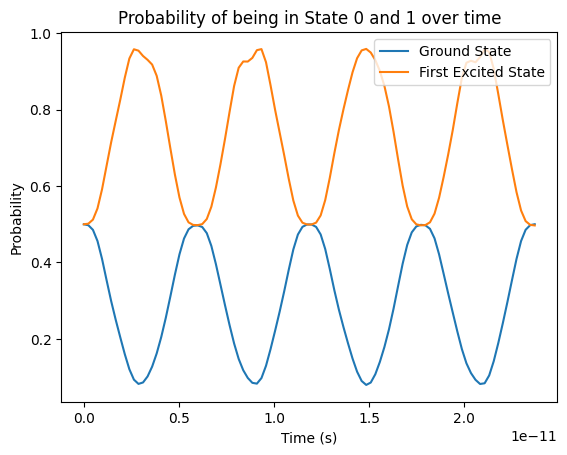

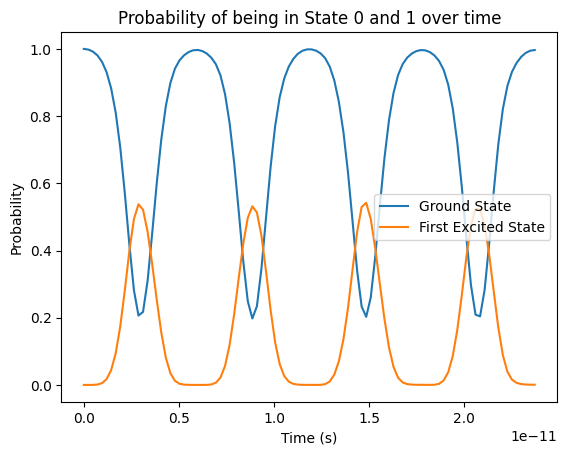

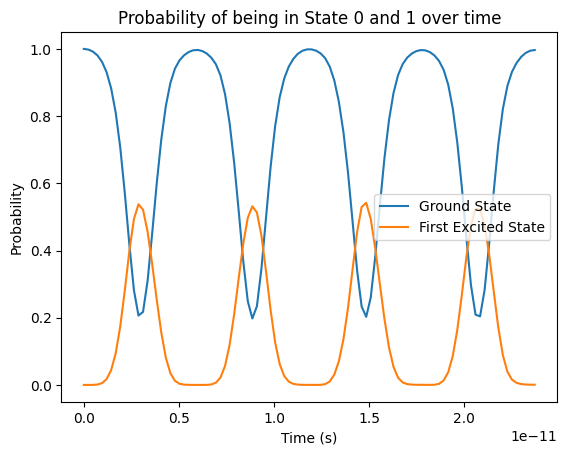

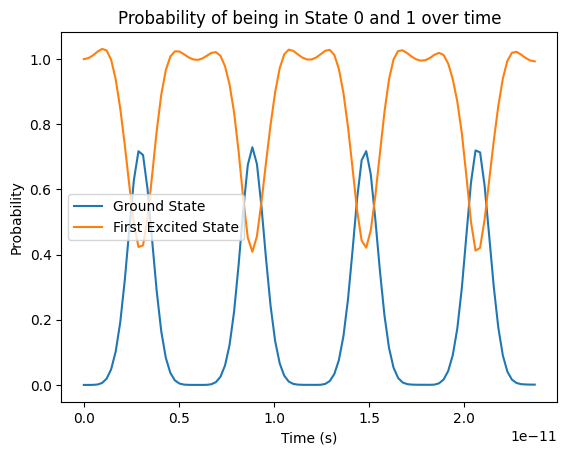

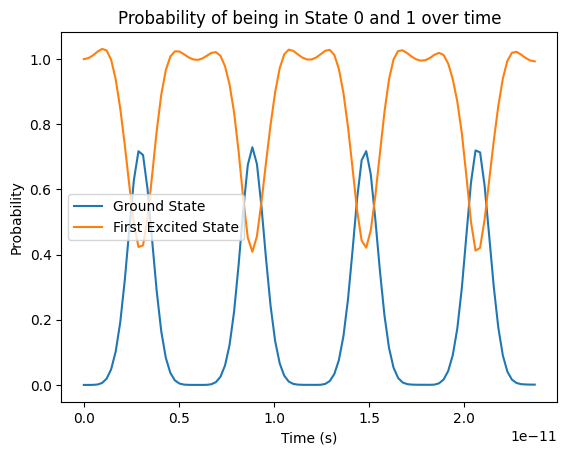

In [220]:
# Start system in a superposition of |0> and |1>
plt.figure(0)
probability_over_time_2X2_system(state0 @ HAD, construct_H(U))

# Starting system in |0>
plt.figure(1)
probability_over_time_2X2_system(state0, construct_H(U))

# Starting system in -|0>
plt.figure(2)
probability_over_time_2X2_system(-state0, construct_H(U))

# Starting system in |1>
plt.figure(3)
probability_over_time_2X2_system(state1, construct_H(U))

# Starting system in -|1>
plt.figure(4)
probability_over_time_2X2_system(state1, construct_H(U))

Interestingly enough, starting the system in state $|0\rangle$and $|1\rangle$ (including the negation of the states) does not change the shape of the probability of occupying a specific state over time(both are still sinusoidal) (tho it looks like there are some instability when starting system in $|1\rangle$.
Starting the system in a superposition of the states seems to favour the first excited state.
This makes sense since the system moves towards the first excited state initially (as evident by the probability curve when start in $|0\rangle$, where the probability of being in ground state drops first).

## Conclusion
In summary, we were able to:
- Analytically solve the Hamiltonian for a 2 x 2 system
- Simulate a single quantum dot (time-independent)
- Simulate a double quantum dot (time-independent)
- Simulate a double quantum dot while under a detuning bias (time-dependent)
    - Determine the conditions required to achieve resonance
    - Investigate if conditions for resonance are not achieved    